In [ ]:
 import tensorflow as tf
print("TF", tf.__version__)
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML, display_html
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output, display_html, HTML
import contextlib
import time
import io
import urllib
import base64

TF 2.8.0


In [ ]:
def clear_and_display_figure(fig, sleep=0.01):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='jpeg')
    img_data.seek(0)
    uri = 'data:image/jpeg;base64,' + urllib.request.quote(base64.b64encode(img_data.getbuffer()))
    img_data.close()
    clear_output(wait=True)
    display_html(HTML('<img src="' + uri + '">'))
    time.sleep(sleep)

# запись анимации для Колаба
class SimpleMovieWriter(object):
    """
    Usage example:
        anim = animation.FuncAnimation(...)
        anim.save(None, writer=SimpleMovieWriter(sleep=0.01))
    """
    def __init__(self, sleep=0.1):
        self.sleep = sleep

    def setup(self, fig):
        self.fig = fig

    def grab_frame(self, **kwargs):
        clear_and_display_figure(self.fig, self.sleep)

    @contextlib.contextmanager
    def saving(self, fig, *args, **kwargs):
        self.setup(fig)
        try:
            yield self
        finally:
            pass

Лосс на одном объекте: $l = (x_1 w_1 + x_2 w_2 - y)^2$

[Каноническое уравнение эллипса](https://ru.wikipedia.org/wiki/Эллипс): $\frac{x_1^2}{a^2} + \frac{x_2^2}{b^2} = 1$, поэтому [линии уровня](https://foxford.ru/wiki/matematika/metod-liniy-urovnya) лосса так выглядят.

Если мы будем увеличивать масштаб $x_1$, это будет сплющивать ось $w_1$ на графике линий уровня.

Разные по масштабу градиенты если разный масштаб признаков:

$ \frac{dl}{dw_1} = 2 (x_1 w_1 + x_2 w_2 - y) x_1$

$ \frac{dl}{dw_2} = 2 (x_1 w_1 + x_2 w_2 - y) x_2$

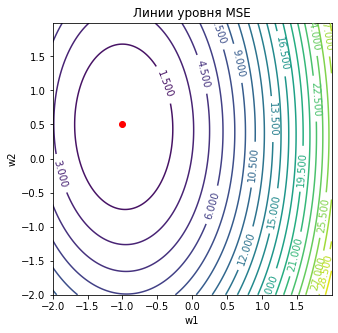

In [ ]:
# генерируем простой датасет
np.random.seed(42)
N = 100
x = np.random.randn(N, 2)
w = np.array([[-1, 0.5]]).T
x[:, 0] *= 2  # признак x1 в x_scale раз больше (создает долины в лоссе)
y = x @ w + np.random.randn(N, 1) * 0.2
    
# рисуем линии уровня лосса в пространстве весов
fig, ax = plt.subplots(figsize=(5, 5))
W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
Z = np.mean((x.dot(np.vstack([W1.ravel(), W2.ravel()])) - y)**2, axis=0).reshape(W1.shape)
contour = ax.contour(W1, W2, Z, 20)
ax.scatter(*w, c='red')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title(u"Линии уровня MSE")
ax.clabel(contour, inline=1, fontsize=10);

In [ ]:
W1

array([[-2.  , -1.99, -1.98, ...,  1.97,  1.98,  1.99],
       [-2.  , -1.99, -1.98, ...,  1.97,  1.98,  1.99],
       [-2.  , -1.99, -1.98, ...,  1.97,  1.98,  1.99],
       ...,
       [-2.  , -1.99, -1.98, ...,  1.97,  1.98,  1.99],
       [-2.  , -1.99, -1.98, ...,  1.97,  1.98,  1.99],
       [-2.  , -1.99, -1.98, ...,  1.97,  1.98,  1.99]])

In [ ]:
W2

array([[-2.  , -2.  , -2.  , ..., -2.  , -2.  , -2.  ],
       [-1.99, -1.99, -1.99, ..., -1.99, -1.99, -1.99],
       [-1.98, -1.98, -1.98, ..., -1.98, -1.98, -1.98],
       ...,
       [ 1.97,  1.97,  1.97, ...,  1.97,  1.97,  1.97],
       [ 1.98,  1.98,  1.98, ...,  1.98,  1.98,  1.98],
       [ 1.99,  1.99,  1.99, ...,  1.99,  1.99,  1.99]])

In [ ]:
# W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
W1 + W2

array([[-4.00000000e+00, -3.99000000e+00, -3.98000000e+00, ...,
        -3.00000000e-02, -2.00000000e-02, -1.00000000e-02],
       [-3.99000000e+00, -3.98000000e+00, -3.97000000e+00, ...,
        -2.00000000e-02, -1.00000000e-02,  3.77475828e-15],
       [-3.98000000e+00, -3.97000000e+00, -3.96000000e+00, ...,
        -1.00000000e-02,  3.55271368e-15,  1.00000000e-02],
       ...,
       [-3.00000000e-02, -2.00000000e-02, -1.00000000e-02, ...,
         3.94000000e+00,  3.95000000e+00,  3.96000000e+00],
       [-2.00000000e-02, -1.00000000e-02,  3.55271368e-15, ...,
         3.95000000e+00,  3.96000000e+00,  3.97000000e+00],
       [-1.00000000e-02,  3.77475828e-15,  1.00000000e-02, ...,
         3.96000000e+00,  3.97000000e+00,  3.98000000e+00]])

In [ ]:
# визуализация шагов
def plot_gd(x_scale, lr, steps, optimizer_name='sgd', start_w = None):
    # генерируем простой датасет
    np.random.seed(42)
    N = 100
    x = np.random.randn(N, 2)
    w = np.array([[-1, 0.5]]).T
    x[:, 0] *= x_scale  # признак x1 в x_scale раз больше (создает долины в лоссе)
    y = x @ w + np.random.randn(N, 1) * 0.2

    w_guess = tf.Variable([[1.5], [1.5]]) if start_w is None else tf.Variable([[start_w[0]], [start_w[1]]])
    loss = lambda: tf.reduce_mean((x @ w_guess - y) ** 2)
    optimizer = tf.keras.optimizers.get(optimizer_name)
    optimizer.lr.assign(lr)
    def optimization_step():
      optimizer.minimize(loss, var_list = w_guess)
    def get_w_guess():
      return w_guess.numpy().T[0]

    # рисуем линии уровня лосса в пространстве весов
    fig, ax = plt.subplots(figsize=(5, 5))
    W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
    Z = np.mean((x.dot(np.vstack([W1.ravel(), W2.ravel()])) - y)**2, axis=0).reshape(W1.shape)
    contour = ax.contour(W1, W2, Z, 20)
    ax.scatter(*w, c='red')
    ax.clabel(contour, inline=1, fontsize=10)
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.title(u"Линии уровня MSE")
    line, = ax.plot([], [], lw=2)

    # стартуем анимацию с пустой траекторией
    def init():
        line.set_data([], [])
        return (line,)

    trajectory = [get_w_guess()]

    # один шаг анимации (шаг бекпроп)
    def animate(i):
        optimization_step()
        trajectory.append(get_w_guess())
        line.set_data(*zip(*trajectory))
        return (line,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=steps, interval=20, blit=True)

    anim.save(None, writer=SimpleMovieWriter(0.0001))
    clear_output(wait=True)

# Простой SGD

У наивного SGD есть проблемы, он плохо сходится когда производные по разным весам слишком разные по масштабу!

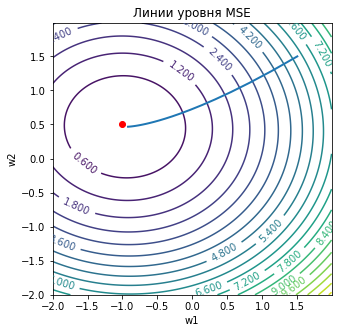

In [ ]:
plot_gd(x_scale=1.0, lr=0.1, steps=25)

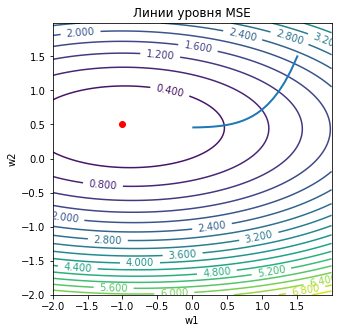

In [ ]:
# узкие долины функции
plot_gd(x_scale=0.5, lr=0.1, steps=25)

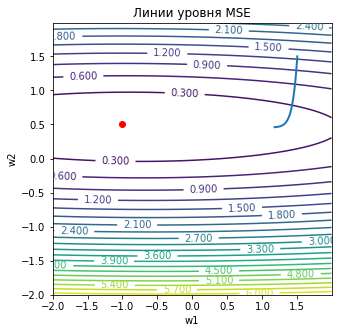

In [ ]:
# еще более узкие
plot_gd(x_scale=0.2, lr=0.1, steps=25)

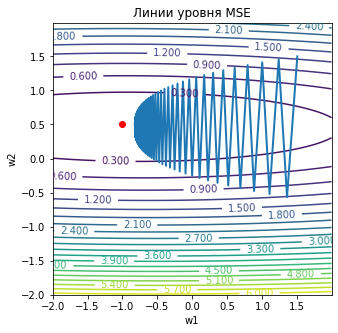

In [ ]:
# попробуем шаг побольше?
# w0 меняется быстрее, но w1 меняется слишком быстро, приводит к осциллированию
plot_gd(x_scale=0.2, lr=1.0, steps=150)

# Adam

Адам работает как зайка, ему не важен масштаб признаков, у него адаптивный learning rate и инерция!

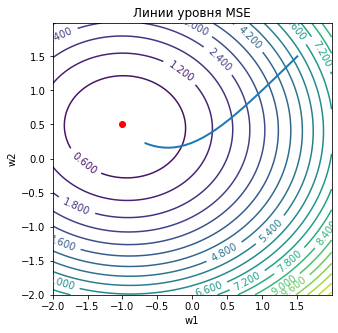

In [ ]:
plot_gd(x_scale=1.0, lr=0.1, steps=25, optimizer_name='adam')

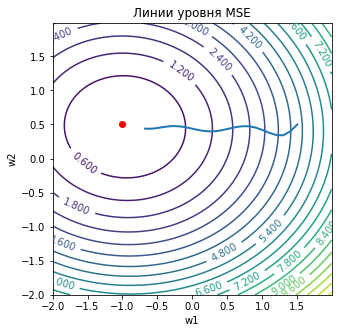

In [ ]:
plot_gd(x_scale=1.0, lr=0.1, steps=25, optimizer_name='adam', start_w = [1.5, 0.5])

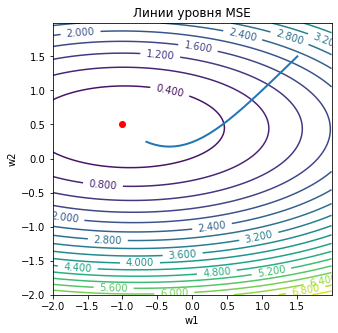

In [ ]:
# узкие долины функции
plot_gd(x_scale=0.5, lr=0.1, steps=25, optimizer_name='adam')

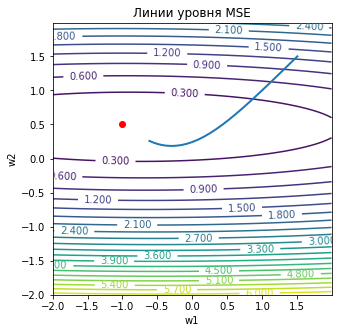

In [ ]:
# еще более узкие
plot_gd(x_scale=0.2, lr=0.1, steps=25, optimizer_name='adam')

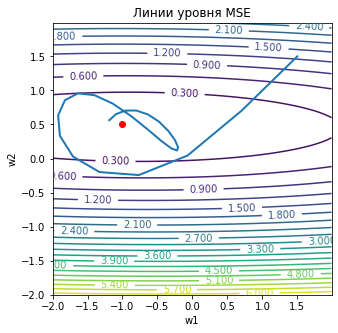

In [ ]:
# сломает ли его шаг побольше?
# слишком большие шаги, закручиваемся вокруг решения из-за момента
plot_gd(x_scale=0.2, lr=0.8, steps=25, optimizer_name='adam')

Если хочется почитать подробнее: 

*   http://cnl.salk.edu/~schraudo/teach/NNcourse/precond.html
*   https://emiliendupont.github.io/2018/01/24/optimization-visualization/